In [29]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [31]:
from pathlib import Path
PROJECT_ROOT = Path("/content/drive/MyDrive/projects/satellite-property-valuation")
DATA_DIR = PROJECT_ROOT / "data"
RAW_DIR = DATA_DIR / "raw"
PROC_DIR = DATA_DIR / "processed"

IMG_DIR = RAW_DIR / "images"

OUT_DIR = PROJECT_ROOT / "outputs"
EMB_DIR = OUT_DIR / "embeddings"
MODEL_DIR = OUT_DIR / "models"


In [32]:
df_train_raw = pd.read_csv(DATA_DIR / "raw/train.csv")
df_test_raw = pd.read_csv(DATA_DIR / "raw/test.csv")

df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   date           16209 non-null  object 
 2   price          16209 non-null  int64  
 3   bedrooms       16209 non-null  int64  
 4   bathrooms      16209 non-null  float64
 5   sqft_living    16209 non-null  int64  
 6   sqft_lot       16209 non-null  int64  
 7   floors         16209 non-null  float64
 8   waterfront     16209 non-null  int64  
 9   view           16209 non-null  int64  
 10  condition      16209 non-null  int64  
 11  grade          16209 non-null  int64  
 12  sqft_above     16209 non-null  int64  
 13  sqft_basement  16209 non-null  int64  
 14  yr_built       16209 non-null  int64  
 15  yr_renovated   16209 non-null  int64  
 16  zipcode        16209 non-null  int64  
 17  lat            16209 non-null  float64
 18  long  

In [33]:
df_train_raw.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


### Price Distribution
Visualize the raw price distribution to understand skewness.


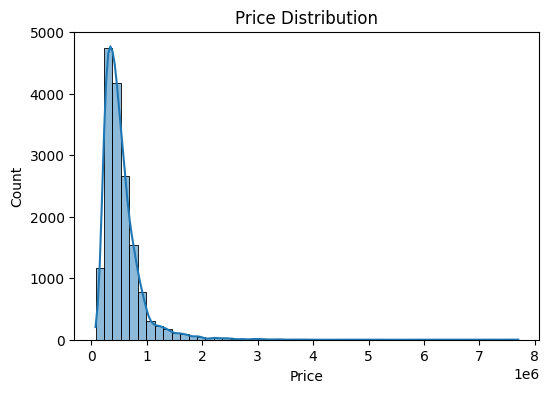

In [34]:
plt.figure(figsize=(6,4))
sns.histplot(df_train_raw["price"], bins=50, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

### Log-Price Distribution
Inspect log-transformed prices to assess normalization effect.


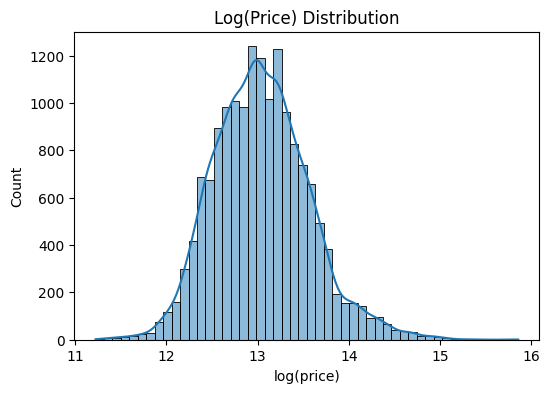

In [35]:
plt.figure(figsize=(6,4))
sns.histplot(np.log(df_train_raw["price"]), bins=50, kde=True)
plt.title("Log(Price) Distribution")
plt.xlabel("log(price)")
plt.ylabel("Count")
plt.show()

### Size vs Price
Analyze relationship between living area and property price.


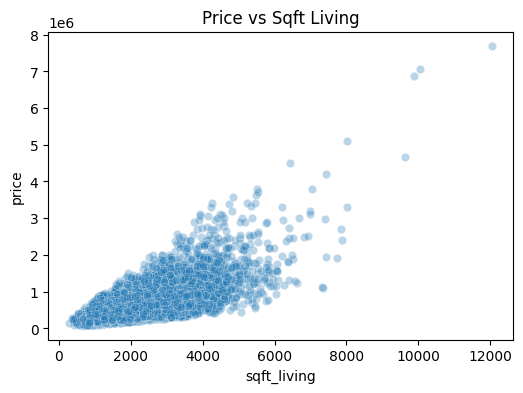

In [36]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=df_train_raw["sqft_living"], y=df_train_raw["price"], alpha=0.3)
plt.title("Price vs Sqft Living")
plt.xlabel("sqft_living")
plt.ylabel("price")
plt.show()

### Grade vs Price
Grade is an ordinal quality score; higher grades correspond to better construction quality.

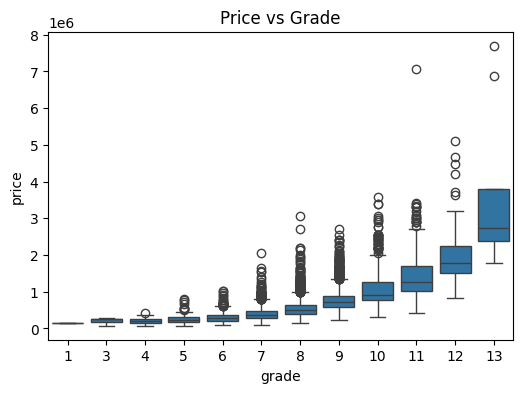

In [37]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df_train_raw["grade"], y=df_train_raw["price"])
plt.title("Price vs Grade")
plt.xlabel("grade")
plt.ylabel("price")
plt.show()


### Geospatial Insight
Prices do not form clear spatial clusters, indicating dependence on fine-grained neighborhood context rather than coarse location alone.


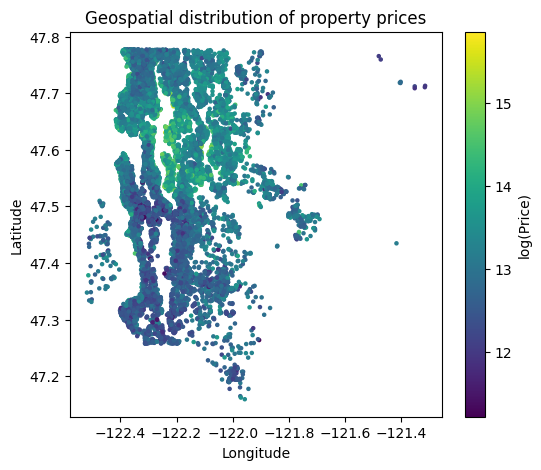

In [38]:
plt.figure(figsize=(6,5))
plt.scatter(
    df_train_raw["long"],
    df_train_raw["lat"],
    c=np.log1p(df_train_raw["price"]),
    cmap="viridis",
    s=5
)
plt.colorbar(label="log(Price)")

plt.title("Geospatial distribution of property prices")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


Raw latitude and longitude do not form sharply separable price clusters. <br>
This suggests that local neighborhood context matters more than coarse geographic position alone.

### Correlation Analysis
Inspect correlations between numeric features to identify strong linear relationships.


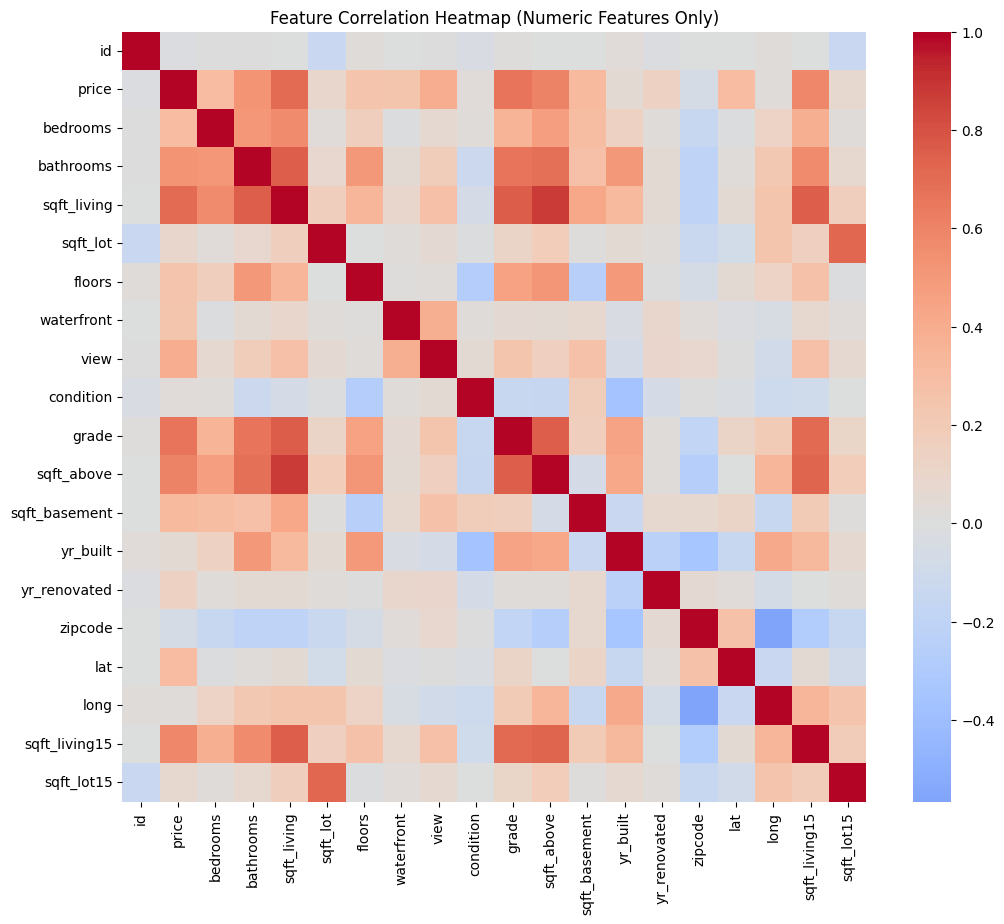

In [39]:
plt.figure(figsize=(12,10))
numeric_df = df_train_raw.select_dtypes(include=[np.number])
corr = numeric_df.corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap (Numeric Features Only)")
plt.show()


### Tabular Preprocessing & Data Export
Apply feature engineering and cleaning to raw tabular data and save the datasets for use later downstream. <br>
NOTE : Categorical and ordinal features are kept numeric for tree-based models, while temporal and renovation effects are explicitly engineered.


In [40]:

import numpy as np
import pandas as pd

TARGET_COL = "price"

DROP_COLS = [
    "zipcode",   # redundant with lat/long
]


def add_date_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])

    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["day_of_week"] = df["date"].dt.dayofweek

    df = df.drop(columns=["date"])
    return df


def add_renovation_feature(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["is_renovated"] = (df["yr_renovated"] > 0).astype(int)
    df = df.drop(columns=["yr_renovated"], errors="ignore")
    return df

def add_building_age(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["building_age"] = df["year"] - df["yr_built"]
    df = df.drop(columns=["yr_built"], errors="ignore")
    return df



def preprocess_tabular(df: pd.DataFrame, is_train: bool = True) -> pd.DataFrame:
    df = df.copy()

    # Feature engineering
    df = add_date_features(df)
    df = add_renovation_feature(df)
    df = add_building_age(df)
    # Ordinal features kept numeric for tree-based models:
    # grade, condition, view, floors


    # Drop non-feature columns
    df = df.drop(columns=DROP_COLS, errors="ignore")

    if is_train:
        df["log_price"] = np.log(df[TARGET_COL])

    return df



In [41]:
df_train_proc = preprocess_tabular(df_train_raw, is_train=True)
df_test_proc  = preprocess_tabular(df_test_raw, is_train=False)
df_train_proc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16209 entries, 0 to 16208
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16209 non-null  int64  
 1   price          16209 non-null  int64  
 2   bedrooms       16209 non-null  int64  
 3   bathrooms      16209 non-null  float64
 4   sqft_living    16209 non-null  int64  
 5   sqft_lot       16209 non-null  int64  
 6   floors         16209 non-null  float64
 7   waterfront     16209 non-null  int64  
 8   view           16209 non-null  int64  
 9   condition      16209 non-null  int64  
 10  grade          16209 non-null  int64  
 11  sqft_above     16209 non-null  int64  
 12  sqft_basement  16209 non-null  int64  
 13  lat            16209 non-null  float64
 14  long           16209 non-null  float64
 15  sqft_living15  16209 non-null  int64  
 16  sqft_lot15     16209 non-null  int64  
 17  year           16209 non-null  int32  
 18  month 

In [46]:
PROC_DIR = Path(DATA_DIR / "processed")
PROC_DIR.mkdir(exist_ok=True)

df_train_proc.to_csv(PROC_DIR / "train_tabular_processed.csv", index=False)
df_test_proc.to_csv(PROC_DIR / "test_tabular_processed.csv", index=False)
df_train_proc.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,long,sqft_living15,sqft_lot15,year,month,day,day_of_week,is_renovated,building_age,log_price
0,9117000170,268643,4,2.25,1810,9240,2.0,0,0,3,...,-122.187,1660,9240,2015,5,5,1,0,54,12.501139
1,6700390210,245000,3,2.50,1600,2788,2.0,0,0,4,...,-122.187,1720,3605,2014,7,8,1,0,22,12.409013
2,7212660540,200000,4,2.50,1720,8638,2.0,0,0,3,...,-122.313,1870,7455,2015,1,15,3,0,21,12.206073
3,8562780200,352499,2,2.25,1240,705,2.0,0,0,3,...,-122.073,1240,750,2015,4,27,0,0,6,12.772803
4,7760400350,232000,3,2.00,1280,13356,1.0,0,0,3,...,-122.074,1590,8071,2014,12,5,4,0,20,12.354493
